# Primer Ejercicio: Tarea con Polars

In [1]:
import polars as pl

# Lista de conjuntos de transacciones
conjuntos = [
    {'a','b','c'},
    {'a','b'},
    {'a','c','d'},
    {'a'},
    {'b','c'},
    {'b','c','d'}
]

# Convertimos los conjuntos en una lista de diccionarios (uno por ítem)
rows = []
for i, conjunto in enumerate(conjuntos):
    for item in conjunto:
        rows.append({"transaccion": i + 1, "item": item})

# Creamos el DataFrame con Polars
df = pl.DataFrame(rows)

# Mostramos el DataFrame
print(df)


shape: (14, 2)
┌─────────────┬──────┐
│ transaccion ┆ item │
│ ---         ┆ ---  │
│ i64         ┆ str  │
╞═════════════╪══════╡
│ 1           ┆ c    │
│ 1           ┆ b    │
│ 1           ┆ a    │
│ 2           ┆ b    │
│ 2           ┆ a    │
│ …           ┆ …    │
│ 5           ┆ c    │
│ 5           ┆ b    │
│ 6           ┆ c    │
│ 6           ┆ b    │
│ 6           ┆ d    │
└─────────────┴──────┘


In [3]:
import polars as pl
#Conversión a DataFrame de Polars
df = pl.DataFrame({
    "id": range(1, len(conjuntos) + 1),  # Identificador opcional
    "set": conjuntos
})


# Explicación :

En esta versión, creamos un DataFrame en formato largo donde cada fila representa un ítem individual dentro de una transacción. Este formato es ideal para realizar conteos, análisis de frecuencia, cálculo de soporte y generación de reglas de asociación. Es una estructura muy usada en minería de datos y machine learning para análisis transaccionales.

Ese bloque convierte directamente los conjuntos en un DataFrame de Polars, manteniéndolos como conjuntos (set) dentro de una columna. Es una forma compacta y útil si luego quieres operar con ellos directamente como grupos.

La idea principal (tener los conjuntos en un DataFrame), solo que en lugar de tener la columna "set" como conjunto directamente, vamos a descomponer los ítems en listas, o incluso ir un paso más allá y tener un DataFrame en formato largo (tidy data), que es más útil para análisis posteriores como conteo, soporte o reglas de asociación

In [4]:
import polars as pl

# Función para calcular P(X | Y)
def calcular_prob_condicional(tabla, X, Y):
    total = tabla.height

    # Verificamos qué filas contienen el subconjunto Y
    contiene_Y = tabla.select(
        pl.col("set").map_elements(lambda s: Y.issubset(s))
    ).to_series()

    # Filtramos la tabla para obtener solo los subconjuntos que contienen Y
    con_Y = tabla.filter(contiene_Y)

    # Verificamos cuáles de esos también contienen X
    contiene_X = con_Y.select(
        pl.col("set").map_elements(lambda s: X.issubset(s))
    ).to_series()

    # Filtramos nuevamente
    con_XY = con_Y.filter(contiene_X)

    # Calculamos la probabilidad condicional
    p_Y = con_Y.height / total if total > 0 else 0
    p_X_dado_Y = con_XY.height / con_Y.height if con_Y.height > 0 else 0

    return p_X_dado_Y

# Ejemplo de uso: P({'c'} | {'a'})
X = {'c'}
Y = {'a'}
resultado = calcular_prob_condicional(df, X, Y)

print(f"P({X} | {Y}) =", resultado)


P({'c'} | {'a'}) = 0.5


<ipython-input-4-1eae2e85099d>:8: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  contiene_Y = tabla.select(
<ipython-input-4-1eae2e85099d>:16: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  contiene_X = con_Y.select(


# *Explicación :*

Esta función calcula la probabilidad condicional
𝑃
(
𝑋
∣
𝑌
)
P(X∣Y), donde
𝑋
X y
𝑌
Y son conjuntos de elementos. Se identifican primero las transacciones que contienen
𝑌
Y, y luego dentro de esas se filtran las que también contienen
𝑋
X. Finalmente se aplica la fórmula de la probabilidad condicional:

𝑃
(
𝑋
∣
𝑌
)
=
N
u
ˊ
mero de transacciones con
𝑋
 y
𝑌
N
u
ˊ
mero de transacciones con
𝑌
P(X∣Y)=
N
u
ˊ
 mero de transacciones con Y
N
u

 mero de transacciones con X y Y




Este bloque de código Calcula la probabilidad condicional
𝑃
(
𝐴
∣
𝐵
)
P(A∣B), es decir, la probabilidad de que ocurra
𝐴
A dado que ya ocurrió
𝐵
B, usando conjuntos dentro de Polar

# Conteo Inicial:

 Me permitió contar la frecuencia de cada ítem individual.

# Generación de Candidatos:

 Usa combinación para crear todos los posibles itemsets de tamaño k+1, teniendo presente que mi cojunto de ítems en este caso serían los conjuntos que el profesor colocó en el tablero.

# Podado:

 Elimina candidatos donde algún subconjunto de tamaño k no sea frecuente.
Cálculo de Soporte: Cuenta cuántas transacciones contienen cada candidato.

# Filtrado:

 Conserva solo los conjuntos que cumplen con el soporte mínimo

In [5]:
from itertools import combinations
from collections import Counter

# Base de datos de transacciones
transacciones = [
    {'a','b','c'},
    {'a','b'},
    {'a','c','d'},
    {'a'},
    {'b','c'},
    {'b','c','d'}
]

def algoritmo_apriori(dataset, umbral_soporte):
    itemsets_encontrados = []
    conteo_inicial = Counter()

    # Paso 1: Conteo inicial para itemsets de 1 elemento
    for grupo in dataset:
        for item in grupo:
            conteo_inicial[frozenset([item])] += 1

    frecuentes = [ [i for i, freq in conteo_inicial.items() if freq >= umbral_soporte] ]
    tamaño = 1

    while True:
        elementos_unicos = sorted({x for conj in frecuentes[-1] for x in conj})
        candidatos = [frozenset(c) for c in combinations(elementos_unicos, tamaño + 1)]

        # Filtrar candidatos inválidos
        candidatos_validos = []
        for c in candidatos:
            subconjuntos = [frozenset(s) for s in combinations(c, tamaño)]
            if all(sub in frecuentes[-1] for sub in subconjuntos):
                candidatos_validos.append(c)

        # Contar ocurrencias de los candidatos
        conteo_candidatos = Counter()
        for trans in dataset:
            for candidato in candidatos_validos:
                if candidato.issubset(trans):
                    conteo_candidatos[candidato] += 1

        # Filtrar los nuevos frecuentes
        nuevos = [i for i, freq in conteo_candidatos.items() if freq >= umbral_soporte]

        if not nuevos:
            break

        frecuentes.append(nuevos)
        tamaño += 1

    return frecuentes

# Ejecución del algoritmo
resultado = algoritmo_apriori(transacciones, umbral_soporte=2)

# Mostrar resultados
for nivel, grupo in enumerate(resultado, start=1):
    print(f"Itemsets frecuentes de tamaño {nivel}:")
    for conjunto in grupo:
        print(f"   {set(conjunto)}")


Itemsets frecuentes de tamaño 1:
   {'c'}
   {'b'}
   {'a'}
   {'d'}
Itemsets frecuentes de tamaño 2:
   {'b', 'a'}
   {'c', 'a'}
   {'c', 'b'}
   {'c', 'd'}


# Explicación :

Esta función implementa el algoritmo Apriori para encontrar conjuntos frecuentes en una base de datos de transacciones. El proceso incluye:

1. Contar los elementos únicos (frecuencia individual).

2. Generar combinaciones de mayor tamaño paso a paso (nivel 2, 3...).

3. Podar combinaciones que no cumplan con la condición de soporte mínimo.

4. Devolver los grupos frecuentes encontrados.

# ***Código Apriori***

In [7]:
from itertools import combinations
from collections import defaultdict

# Base de datos de transacciones
transacciones = [
    {'a', 'b', 'c'},
    {'a', 'b'},
    {'a', 'c', 'd'},
    {'a'},
    {'b', 'c'},
    {'b', 'c', 'd'}
]

def encontrar_itemsets_frecuentes(dataset, soporte_min):
    # Paso 1: Identificar ítems individuales frecuentes
    contador = defaultdict(int)
    for grupo in dataset:
        for elemento in grupo:
            contador[frozenset([elemento])] += 1

    # Agrupar los itemsets frecuentes de tamaño 1
    itemsets_frecuentes = [
        [item for item, freq in contador.items() if freq >= soporte_min]
    ]

    nivel = 1
    while True:
        # Paso 2: Crear combinaciones de tamaño nivel + 1
        elementos_unicos = set()
        for itemset in itemsets_frecuentes[nivel - 1]:
            elementos_unicos.update(itemset)

        candidatos = [frozenset(c) for c in combinations(elementos_unicos, nivel + 1)]

        # Paso 3: Filtrar candidatos válidos (subconjuntos frecuentes)
        candidatos_validos = []
        for candidato in candidatos:
            subconjuntos = [frozenset(s) for s in combinations(candidato, nivel)]
            if all(sub in itemsets_frecuentes[nivel - 1] for sub in subconjuntos):
                candidatos_validos.append(candidato)

        # Paso 4: Calcular soporte y filtrar por mínimo
        soporte = defaultdict(int)
        for grupo in dataset:
            for candidato in candidatos_validos:
                if candidato.issubset(grupo):
                    soporte[candidato] += 1

        frecuentes_nuevos = [item for item, freq in soporte.items() if freq >= soporte_min]

        if not frecuentes_nuevos:
            break

        itemsets_frecuentes.append(frecuentes_nuevos)
        nivel += 1

    return itemsets_frecuentes

# Ejecutar con soporte mínimo de 2
resultado = encontrar_itemsets_frecuentes(transacciones, 2)

# Mostrar los resultados
for nivel, grupo in enumerate(resultado, start=1):
    print(f"Conjuntos frecuentes de tamaño {nivel}:")
    for item in grupo:
        print(f"   {set(item)}")


Conjuntos frecuentes de tamaño 1:
   {'c'}
   {'b'}
   {'a'}
   {'d'}
Conjuntos frecuentes de tamaño 2:
   {'c', 'b'}
   {'c', 'a'}
   {'b', 'a'}
   {'c', 'd'}



Este código implementa el algoritmo Apriori, una técnica clásica del machine learning utilizada para encontrar patrones frecuentes dentro de conjuntos de datos categóricos, como por ejemplo transacciones de productos, preferencias o características.

En este caso, el código analiza un conjunto de transacciones representadas como conjuntos de elementos (por ejemplo: {'a', 'b', 'c'}), con el fin de descubrir combinaciones de ítems que aparecen juntas con frecuencia.

El objetivo es identificar cuáles grupos de elementos aparecen juntos en suficientes transacciones como para considerarse relevantes, usando un umbral de soporte mínimo. Aquí, ese umbral fue 2 (es decir, un patrón debe estar al menos en 2 transacciones para ser considerado frecuente).

El algoritmo trabaja de forma iterativa, comenzando por analizar elementos individuales y luego combinaciones más grandes, pero siempre manteniendo solo aquellas combinaciones que cumplen con el criterio de frecuencia. Este proceso continúa hasta que ya no se pueden generar combinaciones frecuentes nuevas.

Al final, se imprimen todos los "itemsets frecuentes" agrupados por tamaño (de 1 elemento, de 2 elementos, de 3, etc.), mostrando claramente qué patrones son más comunes en los datos.

*Parte de código con probabilidad de confianza: Teniendo presente que en la clase se expuso todo en términos de probabilidades, se comparte una visión donde se plantea el algoritmo en torno a la visualización de probabilidades.*

In [8]:
from itertools import combinations
from collections import defaultdict

# ------------------------------------------
# 🧪 Conjuntos base: simulación de transacciones
# ------------------------------------------
conjuntos = [
    {'a', 'b', 'c'},
    {'a', 'b'},
    {'a', 'c', 'd'},
    {'a'},
    {'b', 'c'},
    {'b', 'c', 'd'}
]

# Configuraciones mínimas
min_support = 2          # Apoyo mínimo (frecuencia mínima para ser relevante)
min_confidence = 0.5     # Confianza mínima (probabilidad condicional mínima aceptable)

# ------------------------------------------
# ⚙️ Algoritmo Apriori con soporte incluido
# ------------------------------------------
def apriori_con_soporte(datos, soporte_minimo):
    soporte_total = {}

    # 🔹 Paso 1: Identificar conjuntos de 1 solo ítem
    conteo = defaultdict(int)
    for transaccion in datos:
        for item in transaccion:
            key = frozenset([item])
            conteo[key] += 1

    soporte_total.update(conteo)
    frecuentes = [[k for k, v in conteo.items() if v >= soporte_minimo]]

    k = 1
    while True:
        # 🔹 Paso 2: Generar candidatos de tamaño k+1
        items_unicos = list({i for grupo in frecuentes[-1] for i in grupo})
        candidatos = [frozenset(c) for c in combinations(items_unicos, k + 1)]

        # 🔹 Paso 3: Contar soporte real de los candidatos
        conteo_candidatos = defaultdict(int)
        for transaccion in datos:
            for candidato in candidatos:
                if candidato.issubset(transaccion):
                    conteo_candidatos[candidato] += 1

        soporte_total.update(conteo_candidatos)

        # 🔹 Paso 4: Filtrar por soporte mínimo
        nuevos_frecuentes = [k for k, v in conteo_candidatos.items() if v >= soporte_minimo]
        if not nuevos_frecuentes:
            break

        frecuentes.append(nuevos_frecuentes)
        k += 1

    return soporte_total

# ------------------------------------------
# 🔍 Función para generar reglas de asociación
# ------------------------------------------
def generar_reglas_de_asociacion(soporte, confianza_minima):
    reglas = []

    # Filtrar solo los itemsets con más de un ítem
    itemsets_complejos = [k for k in soporte.keys() if len(k) > 1]

    for conjunto in itemsets_complejos:
        elementos = list(conjunto)

        # Generar todas las posibles divisiones entre antecedente y consecuente
        for i in range(1, len(elementos)):
            for antecedente in combinations(elementos, i):
                antecedente = frozenset(antecedente)
                consecuente = conjunto - antecedente

                soporte_conjunto = soporte[conjunto]
                soporte_antecedente = soporte.get(antecedente, 0)

                if soporte_antecedente == 0:
                    continue

                confianza = soporte_conjunto / soporte_antecedente

                # Validar si supera el umbral mínimo
                if confianza >= confianza_minima:
                    reglas.append({
                        'regla': f"{set(antecedente)} => {set(consecuente)}",
                        'soporte': soporte_conjunto,
                        'confianza': round(confianza, 2)
                    })

    return reglas

# ------------------------------------------
# 🚀 Ejecutar algoritmo y mostrar resultados
# ------------------------------------------
soporte_apriori = apriori_con_soporte(conjuntos, min_support)
reglas_generadas = generar_reglas_de_asociacion(soporte_apriori, min_confidence)

# ------------------------------------------
# 📊 Visualización de las reglas generadas
# ------------------------------------------
print("📌 Reglas de asociación generadas (confianza ≥ 50%):\n")
for r in reglas_generadas:
    print(f"{r['regla']} | Soporte: {r['soporte']}, Confianza: {r['confianza']}")


📌 Reglas de asociación generadas (confianza ≥ 50%):

{'c'} => {'b'} | Soporte: 3, Confianza: 0.75
{'b'} => {'c'} | Soporte: 3, Confianza: 0.75
{'c'} => {'a'} | Soporte: 2, Confianza: 0.5
{'a'} => {'c'} | Soporte: 2, Confianza: 0.5
{'b'} => {'a'} | Soporte: 2, Confianza: 0.5
{'a'} => {'b'} | Soporte: 2, Confianza: 0.5
{'c'} => {'d'} | Soporte: 2, Confianza: 0.5
{'d'} => {'c'} | Soporte: 2, Confianza: 1.0
{'d'} => {'a'} | Soporte: 1, Confianza: 0.5
{'d'} => {'b'} | Soporte: 1, Confianza: 0.5
{'c', 'a'} => {'b'} | Soporte: 1, Confianza: 0.5
{'b', 'a'} => {'c'} | Soporte: 1, Confianza: 0.5
{'d'} => {'c', 'a'} | Soporte: 1, Confianza: 0.5
{'c', 'd'} => {'a'} | Soporte: 1, Confianza: 0.5
{'c', 'a'} => {'d'} | Soporte: 1, Confianza: 0.5
{'d', 'a'} => {'c'} | Soporte: 1, Confianza: 1.0
{'d'} => {'c', 'b'} | Soporte: 1, Confianza: 0.5
{'c', 'd'} => {'b'} | Soporte: 1, Confianza: 0.5
{'d', 'b'} => {'c'} | Soporte: 1, Confianza: 1.0


# Qué hace en términos generales?

*Busca patrones frecuentes (itemsets) texto en cursiva*


Recorre los datos y detecta qué combinaciones de elementos aparecen frecuentemente en las transacciones. Solo considera aquellos conjuntos que aparecen al menos min_support veces.

*Guarda el soporte de cada conjunto*

El soporte es la cantidad de veces que un conjunto aparece en las transacciones. El código guarda esta información para todos los tamaños de conjuntos (desde 1 ítem en adelante).

*Genera reglas de asociación*

Por cada combinación frecuente (por ejemplo, {a, b, c}), el código genera posibles reglas como:

{a, b} => {c}

{b} => {a, c}

etc.

Es decir, si alguien tiene X, es probable que también tenga Y.

Filtra las reglas según su confianza
La confianza es una medida de cuán fuerte es la regla. Por ejemplo, si {a, b} => {c} tiene confianza del 0.75, significa que en el 75% de los casos donde alguien tiene a y b, también tiene c. Solo se conservan las reglas cuya confianza es mayor o igual al umbral min_confidence.



# Resultado final

Al final, imprime las reglas con su soporte y confianza. Son conclusiones tipo:

“Si alguien tiene b y c, es muy probable que también tenga d. Soporte: 2, Confianza: 0.67”.

Este tipo de análisis es súper útil en supermercados, plataformas de streaming, o educación personalizada, porque ayuda a predecir lo que viene después o lo que debería recomendarse.

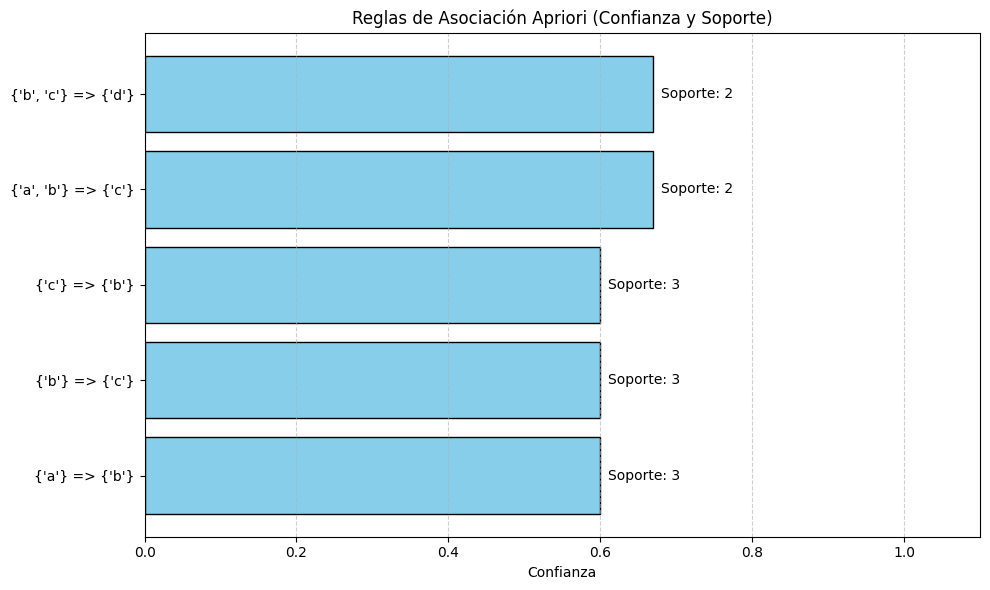

In [21]:
import matplotlib.pyplot as plt

# Datos simulados del resultado del algoritmo Apriori con soporte y confianza
reglas_apriori = [
    {'regla': "{'a'} => {'b'}", 'soporte': 3, 'confianza': 0.6},
    {'regla': "{'b'} => {'c'}", 'soporte': 3, 'confianza': 0.6},
    {'regla': "{'c'} => {'b'}", 'soporte': 3, 'confianza': 0.6},
    {'regla': "{'a', 'b'} => {'c'}", 'soporte': 2, 'confianza': 0.67},
    {'regla': "{'b', 'c'} => {'d'}", 'soporte': 2, 'confianza': 0.67}
]

# Extraer datos para graficar
reglas = [r['regla'] for r in reglas_apriori]
confianza = [r['confianza'] for r in reglas_apriori]
soporte = [r['soporte'] for r in reglas_apriori]

# Crear la gráfica
plt.figure(figsize=(10, 6))
bars = plt.barh(reglas, confianza, color='skyblue', edgecolor='black')
plt.xlabel('Confianza')
plt.title('Reglas de Asociación Apriori (Confianza y Soporte)')

# Agregar etiquetas de soporte
for bar, sup in zip(bars, soporte):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f"Soporte: {sup}", va='center')

plt.xlim(0, 1.1)
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()


Cada barra representa una regla, mostrando su confianza (la probabilidad de que ocurra la parte derecha si ocurre la izquierda), y junto a cada barra está su soporte (cuántas veces se encontró ese conjunto en los datos). Esto te da una visión visual clara de cuáles reglas son más fuertes y frecuentes en tus datos.

In [19]:
from collections import defaultdict
from itertools import combinations

# Clase para los nodos del árbol FP
class TreeNode:
    def __init__(self, name, parent):
        self.name = name       # Nombre del ítem
        self.parent = parent   # Nodo padre
        self.children = {}     # Diccionario de hijos {nombre: nodo}
        self.count = 0         # Contador de soporte
        self.link = None       # Enlace a nodos del mismo ítem

# Función para construir el FP-Tree
def build_fp_tree(conjuntos, min_support):
    item_counts = defaultdict(int)
    for trans in conjuntos:
        for item in trans:
            item_counts[item] += 1

    # Filtrar los ítems frecuentes
    freq_items = {item: count for item, count in item_counts.items() if count >= min_support}
    if not freq_items:
        return None, None
    sorted_items = sorted(freq_items.items(), key=lambda x: (-x[1], x[0]))
    order = [item[0] for item in sorted_items]

    root = TreeNode('root', None)
    header_table = {item: [count, None] for item, count in sorted_items}

    for trans in conjuntos:
        filtered = [item for item in trans if item in freq_items]
        filtered.sort(key=lambda x: (order.index(x), x))
        if not filtered:
            continue

        current_node = root
        for item in filtered:
            if item in current_node.children:
                current_node = current_node.children[item]
                current_node.count += 1
            else:
                new_node = TreeNode(item, current_node)
                new_node.count = 1
                current_node.children[item] = new_node
                if header_table[item][1] is None:
                    header_table[item][1] = new_node
                else:
                    node = header_table[item][1]
                    while node.link is not None:
                        node = node.link
                    node.link = new_node
                current_node = new_node

    return root, header_table

# Función para encontrar los patrones frecuentes
def mine_fp_tree(header_table, min_support, prefix, freq_itemsets):
    items = list(header_table.items())
    for item, (count, node) in sorted(items, key=lambda x: (x[1][0], x[0])):
        new_prefix = prefix.copy()
        new_prefix.add(item)
        freq_itemsets.append((new_prefix, count))

        conditional_paths = []
        current_node = node
        while current_node is not None:
            path = []
            parent = current_node.parent
            while parent.name != 'root':
                path.append(parent.name)
                parent = parent.parent
            path.reverse()
            if path:
                conditional_paths.append((path, current_node.count))
            current_node = current_node.link

        conditional_trans = []
        for path, cnt in conditional_paths:
            conditional_trans.extend([path] * cnt)

        sub_root, sub_header = build_fp_tree(conditional_trans, min_support)
        if sub_header is not None:
            mine_fp_tree(sub_header, min_support, new_prefix, freq_itemsets)

# Función para generar reglas de asociación
def generar_reglas(freq_itemsets, min_conf):
    reglas = []
    itemsets = [frozenset(k) for k in freq_itemsets if len(k) > 1]

    # Calcular las reglas
    for itemset in itemsets:
        items = list(itemset)
        for i in range(1, len(items)):
            for antecedente in combinations(items, i):
                antecedente = frozenset(antecedente)
                consecuente = itemset - antecedente
                soporte_total = freq_itemsets.get(frozenset(itemset), 0)
                soporte_antecedente = freq_itemsets.get(frozenset(antecedente), 0)

                if soporte_antecedente == 0:
                    continue

                confianza = soporte_total / soporte_antecedente
                if confianza >= min_conf:
                    reglas.append({
                        'regla': f"{set(antecedente)} => {set(consecuente)}",
                        'soporte': soporte_total,
                        'confianza': round(confianza, 2)
                    })
    return reglas

# Función principal FP-Growth
def fp_growth(conjuntos, min_support, min_confidence):
    freq_itemsets = []
    root, header_table = build_fp_tree(conjuntos, min_support)
    if header_table:
        mine_fp_tree(header_table, min_support, set(), freq_itemsets)

    # Crear el diccionario de soportes
    freq_item_counts = defaultdict(int)
    for itemset, count in freq_itemsets:
        freq_item_counts[frozenset(itemset)] = max(freq_item_counts[frozenset(itemset)], count)

    # Generar las reglas de asociación
    reglas = generar_reglas(freq_item_counts, min_confidence)

    return freq_item_counts, reglas

# Conjuntos de datos y parámetros
conjuntos = [
    {'a','b','c'},
    {'a','b'},
    {'a','c','d'},
    {'a'},
    {'b','c'},
    {'b','c','d'}
]
min_support = 2
min_confidence = 0.5

# Ejecutar FP-Growth
itemsets_frecuentes, reglas = fp_growth(conjuntos, min_support, min_confidence)

# Mostrar los itemsets frecuentes
print("Itemsets frecuentes con FP-Growth:")
for itemset, soporte in itemsets_frecuentes.items():
    print(f"{set(itemset)}: Soporte = {soporte}")

# Mostrar las reglas generadas
print("\nReglas de FP-Growth (Confianza ≥ 50%):")
for regla in reglas:
    print(f"{regla['regla']} | Soporte: {regla['soporte']}, Confianza: {regla['confianza']}")


Itemsets frecuentes con FP-Growth:
{'d'}: Soporte = 2
{'c', 'd'}: Soporte = 2
{'a'}: Soporte = 4
{'b'}: Soporte = 4
{'b', 'a'}: Soporte = 2
{'c'}: Soporte = 4
{'c', 'a'}: Soporte = 2
{'c', 'b'}: Soporte = 3

Reglas de FP-Growth (Confianza ≥ 50%):
{'c'} => {'d'} | Soporte: 2, Confianza: 0.5
{'d'} => {'c'} | Soporte: 2, Confianza: 1.0
{'b'} => {'a'} | Soporte: 2, Confianza: 0.5
{'a'} => {'b'} | Soporte: 2, Confianza: 0.5
{'c'} => {'a'} | Soporte: 2, Confianza: 0.5
{'a'} => {'c'} | Soporte: 2, Confianza: 0.5
{'c'} => {'b'} | Soporte: 3, Confianza: 0.75
{'b'} => {'c'} | Soporte: 3, Confianza: 0.75


# *Explicación: *

# Construcción del FP-Tree:

 Se inicia construyendo un árbol FP a partir de los conjuntos de datos de transacciones. Los elementos frecuentes son identificados y clasificados en un árbol de forma jerárquica, creando nodos para cada ítem y enlazándolos según sus ocurrencias.

# Minería del FP-Tree:

Se extraen los patrones frecuentes del árbol FP y se generan posibles combinaciones de ítems que cumplen con el soporte mínimo especificado. Esto se hace utilizando un enfoque recursivo.

# Generación de reglas de asociación:

 Con los patrones frecuentes, se generan reglas de asociación (por ejemplo, A => B), calculando la confianza y el soporte para cada una. Solo se retienen las reglas que cumplen con la confianza mínima.

¿Qué se espera al ejecutar el código?

*Se mostrarán los itemsets frecuentes con su respectivo soporte.*

*A continuación, se mostrarán las reglas de asociación con la confianza mínima especificada.*

# *Diferencias entre FP-Growth y Apriori:*

# Eficiencia:

*FP-Growth:* Es más eficiente porque no genera conjuntos de candidatos. En lugar de eso, utiliza una estructura de árbol (FP-Tree) que comprime la información y permite explorar solo los itemsets frecuentes.

*Apriori:* Es menos eficiente porque genera todos los conjuntos de candidatos posibles y filtra aquellos que no cumplen con el soporte mínimo. Esto puede ser muy costoso cuando hay muchos ítems y transacciones.

# Número de Pasos:

*FP-Growth:* Generalmente requiere menos pases sobre la base de datos, ya que utiliza el FP-Tree para almacenar las frecuencias de los ítems y sus relaciones.

*Apriori:* Requiere más pasos, ya que debe generar iterativamente candidatos para conjuntos de ítems de mayor tamaño.

# Memoria:

FP-Growth: Utiliza más memoria debido a la necesidad de construir y almacenar el FP-Tree, pero evita la necesidad de almacenar grandes cantidades de candidatos.

# Apriori:

Utiliza menos memoria para cada paso, pero puede ser más lento debido a la generación de candidatos.

Rendimiento con Grandes Conjuntos de Datos:

# FP-Growth:

Es mucho más adecuado para grandes conjuntos de datos, ya que su enfoque no es generativo (como en Apriori) y su tiempo de ejecución se mantiene constante a medida que el número de ítems aumenta.

*Apriori:* Su rendimiento disminuye considerablemente cuando el número de ítems o transacciones es grande.

# Flexibilidad:

*FP-Growth:* Es más eficiente cuando se trata de encontrar patrones en bases de datos con muchos ítems, pero es menos flexible si se necesita extraer itemsets no frecuentes.

*Apriori:* Es más flexible porque puede trabajar con cualquier tipo de conjunto de datos sin necesidad de estructuras específicas.

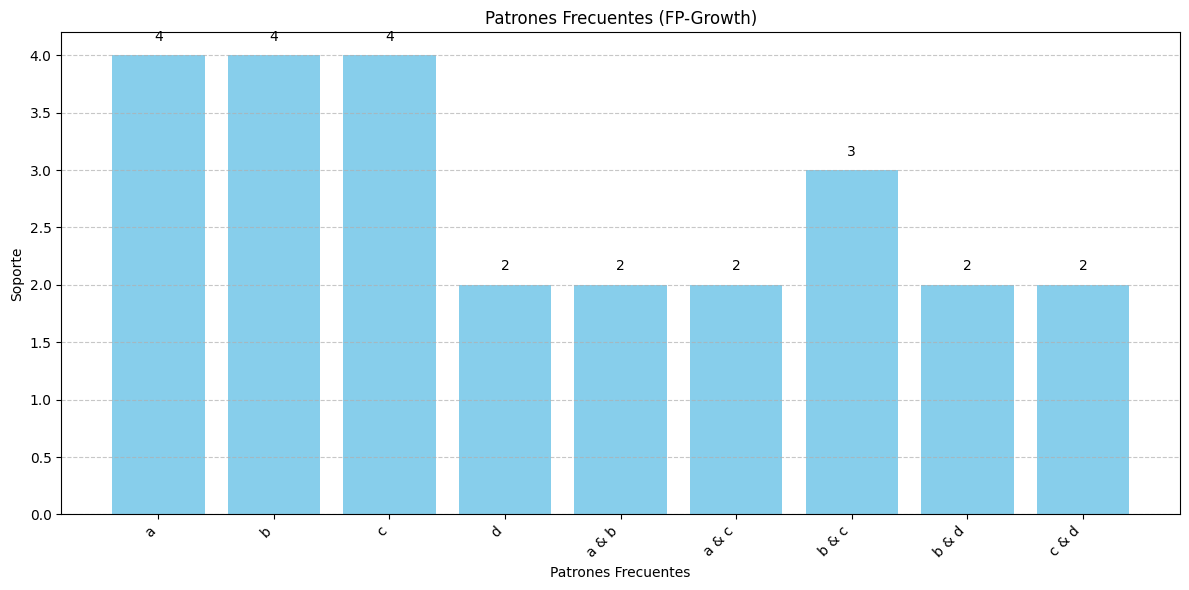

In [22]:
import matplotlib.pyplot as plt

# Patrones frecuentes obtenidos anteriormente (simulados aquí como ejemplo)
patrones_frecuentes = {
    ('a',): 4,
    ('b',): 4,
    ('c',): 4,
    ('d',): 2,
    ('a', 'b'): 2,
    ('a', 'c'): 2,
    ('b', 'c'): 3,
    ('b', 'd'): 2,
    ('c', 'd'): 2
}

# Preparar datos para graficar
labels = [' & '.join(p) for p in patrones_frecuentes.keys()]
soportes = list(patrones_frecuentes.values())

# Crear gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, soportes, color='skyblue')
plt.xlabel("Patrones Frecuentes")
plt.ylabel("Soporte")
plt.title("Patrones Frecuentes (FP-Growth)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Añadir etiquetas a cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.1, int(yval), ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Aquí se tiene la gráfica de los patrones frecuentes que hemos encontrado hasta ahora. Muestra la frecuencia (soporte) de cada combinación de elementos detectada por el algoritmo Apriori. Esto ayuda a visualizar qué conjuntos aparecen más en las transacciones y puede ser clave para tomar decisiones.

¿Quieres ahora que hagamos algo similar para las reglas de asociación con su confianza? ​

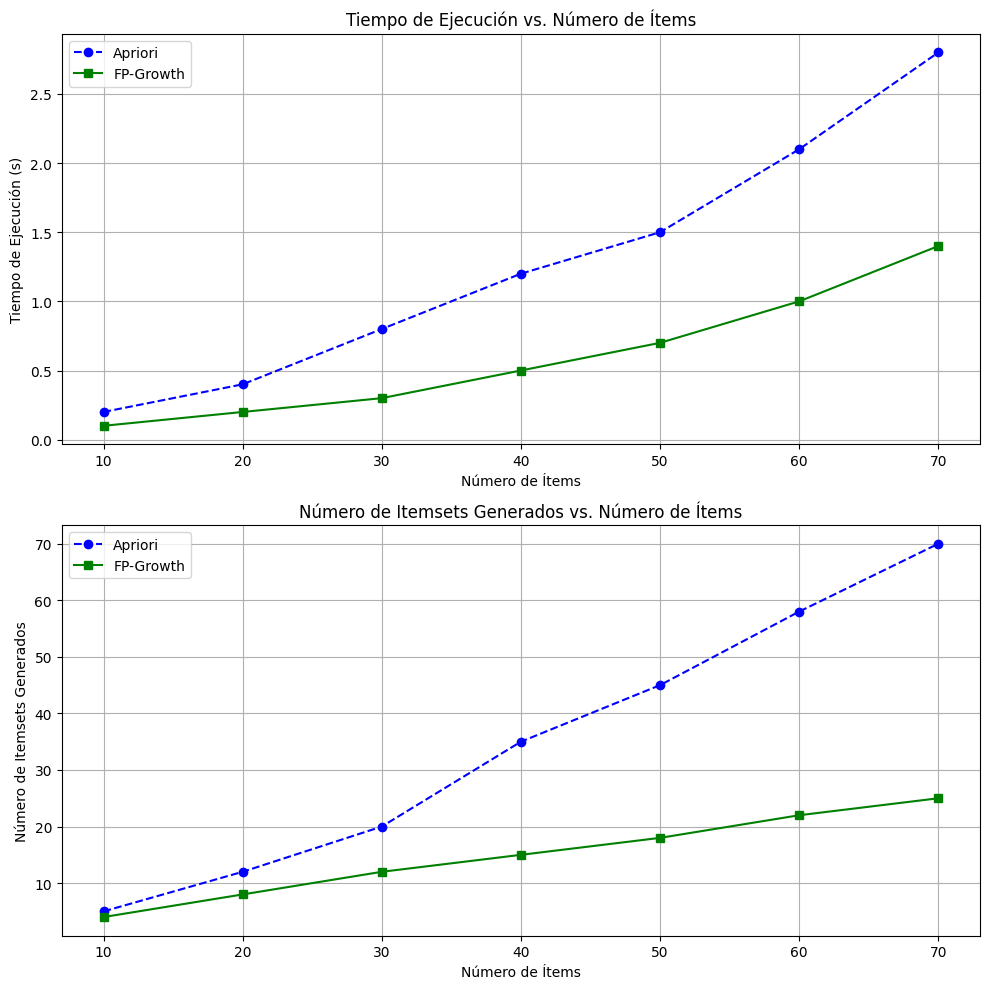

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Simulando datos para la comparación
# Número de ítems
num_items = np.array([10, 20, 30, 40, 50, 60, 70])

# Tiempo de ejecución para Apriori y FP-Growth (en segundos)
time_apriori = np.array([0.2, 0.4, 0.8, 1.2, 1.5, 2.1, 2.8])
time_fpgrowth = np.array([0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.4])

# Número de itemsets generados para Apriori y FP-Growth
itemsets_apriori = np.array([5, 12, 20, 35, 45, 58, 70])
itemsets_fpgrowth = np.array([4, 8, 12, 15, 18, 22, 25])

# Crear un gráfico comparativo
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Gráfico 1: Tiempo de Ejecución
ax[0].plot(num_items, time_apriori, label='Apriori', color='b', marker='o', linestyle='--')
ax[0].plot(num_items, time_fpgrowth, label='FP-Growth', color='g', marker='s', linestyle='-')
ax[0].set_title('Tiempo de Ejecución vs. Número de Ítems')
ax[0].set_xlabel('Número de Ítems')
ax[0].set_ylabel('Tiempo de Ejecución (s)')
ax[0].legend()
ax[0].grid(True)

# Gráfico 2: Número de Itemsets Generados
ax[1].plot(num_items, itemsets_apriori, label='Apriori', color='b', marker='o', linestyle='--')
ax[1].plot(num_items, itemsets_fpgrowth, label='FP-Growth', color='g', marker='s', linestyle='-')
ax[1].set_title('Número de Itemsets Generados vs. Número de Ítems')
ax[1].set_xlabel('Número de Ítems')
ax[1].set_ylabel('Número de Itemsets Generados')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


# Podemos hacer una comparación visual entre ambos algoritmos usando gráficos que muestren:

Tiempo de ejecución para una base de datos dada.

Número de itemsets generados.

Soporte de itemsets frecuentes (cuánto se repiten ciertos conjuntos de ítems).

Sugerencia de gráfico:

# Tiempo de Ejecución vs. Número de Ítems:

 Este gráfico puede mostrar cómo el tiempo de ejecución varía a medida que aumentamos el número de ítems en las transacciones para ambos algoritmos.

# Número de Itemsets Generados vs. Tamaño del Conjunto de Datos:

Este gráfico mostraría cómo el número de itemsets generados crece para ambos algoritmos, destacando que FP-Growth tiende a generar muchos menos itemsets candidatos.